# **1- Importing necessary packages**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [2]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ihjja_kz
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ihjja_kz
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0f84004a0ede6e4cb87f98edbf46f6c2784b002bd_-cp36-none-any.whl size=126412 sha256=b4f3332d21142902af5f8dc37e8a0e94f85d165d110ec04c0eb56a46b977d08a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qnr66eh/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import os
import math
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow import keras
#from keras.preprocessing.sequence import TimeSeriesGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
#from Ipython.display import clear_output
import tensorflow.compat.v2.feature_column as fc
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **2- Importing the training set and validation set for electricity or heating demand**

In [12]:
from google.colab import files
uploaded = files.upload() # u can now upload the datasetst

Saving X_test_MZVAV.csv to X_test_MZVAV (1).csv
Saving X_train_MZVAV.csv to X_train_MZVAV (1).csv
Saving Y_test_MZVAV.csv to Y_test_MZVAV.csv
Saving Y_train_MZVAV.csv to Y_train_MZVAV.csv


In [13]:
import io
X_train=pd.read_csv(io.BytesIO(uploaded["X_train_MZVAV.csv"]))   # import the training dataset that is preprocessed by the data_prepration pipeline 
Y_train=pd.read_csv(io.BytesIO(uploaded["X_train_MZVAV.csv"])) 

X_test=pd.read_csv(io.BytesIO(uploaded["X_test_MZVAV.csv"]))    # import the test dataset.
Y_test=pd.read_csv(io.BytesIO(uploaded["Y_test_MZVAV.csv"])) 


In [14]:
X_train

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,1/30/2017 0:00,68.00,55.04,32.00,68.00,75.20,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
1,1/30/2017 0:01,67.99,55.04,32.00,66.71,75.20,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
2,1/30/2017 0:02,67.99,55.04,-5.93,66.71,74.45,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
3,1/30/2017 0:03,67.99,55.04,-5.88,66.71,74.04,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
4,1/30/2017 0:04,67.99,55.04,-5.83,66.71,73.56,0,0,0.0,0.0,0.0,0.0,0.00,0,0.04,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272155,12/17/2017 23:55,55.04,55.04,17.89,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272156,12/17/2017 23:56,55.04,55.04,17.87,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272157,12/17/2017 23:57,55.04,55.04,17.85,62.52,62.53,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1
272158,12/17/2017 23:58,55.04,55.04,17.83,62.52,62.52,1,1,1.0,1.0,0.0,0.0,0.01,0,0.04,0.11,0,1


# **3- Creating a function to define mini-batch size and epoch numbers**

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=5600):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(48)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into 10 mini-batches, each of size 5600 (70080*0.8/10), and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

Train_input_fn = make_input_fn(X_train, Y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
Eval_input_fn = make_input_fn(X_test, Y_tes, num_epochs=1, shuffle=False)

# **4- Creating a function to define feature columns**


In [ ]:
# Feature columns describe how to use the input.
def my_feature_columns(data_df):
  my_feature_columns = []
  for key in data_df.keys():
      my_feature_columns.append(tf.feature_column.numeric_column(key=key))
  print(my_feature_columns)

# **5- Creating the model (Construction phase)**

# **S,DTO-DRNN_2LSTM**

**Comments for creating the final model**


1.   The initial LSTM layer requires a specification of its input_shape. To correctly specify this, follow this simple rule: take the X_train.shape: (1847, 90, 1), drop the first dimension: (90, 1), there you have the correct input_shape. It's as easy as that.
2.  For Deep RNNs, each LSTM() that is not the last requires return_sequences = True. That is because an LSTM layer that is not outputting to Dense() layers must receive a series of data to be processed, so you want other layers to return a sequence of data of a kind similar to your input. 
*   Dense() layer has the same size of the previous LSTMs output sequence. This intermediate layer fires to the output layer, that has a number of nodes equal to the number of forecast steps. Regression tasks require no activation function at the output layer, since no activation means linear activation.









In [5]:
lstm1 = tf.keras.layers.LSTM(    input_shape=(24,12),units=400, activation='tanh',
                                recurrent_activation='sigmoid', use_bias=True, dropout=0.2, return_sequences=True
                                                                                   )   

In [6]:
lstm2 = tf.keras.layers.LSTM(    units=400, activation='tanh',
                                recurrent_activation='sigmoid', use_bias=True, dropout=0.2, return_sequences=True
                                                                                   )   

In [7]:
mlp1 = tf.keras.layers.Dense(15, activation="sigmoid")
mlp2 = tf.keras.layers.Dense(15, activation="sigmoid")
mlp3 = tf.keras.layers.Dense(1, activation="sigmoid")

In [8]:
dropout = tf.keras.layers.Dropout(0.2, noise_shape=None) # 
l2 = tf.keras.regularizers.l2(l=0.01)

Model: "S_DTO-DRNN_2LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 12)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 24, 400)           660800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 400)           1281600   
_________________________________________________________________
dense (Dense)                (None, 24, 15)            6015      
_________________________________________________________________
dense_1 (Dense)              (None, 24, 15)            240       
_________________________________________________________________
dense_2 (Dense)              (None, 24, 1)             16        
Total params: 1,948,671
Trainable params: 1,948,671
Non-trainable params: 0
________________________________________

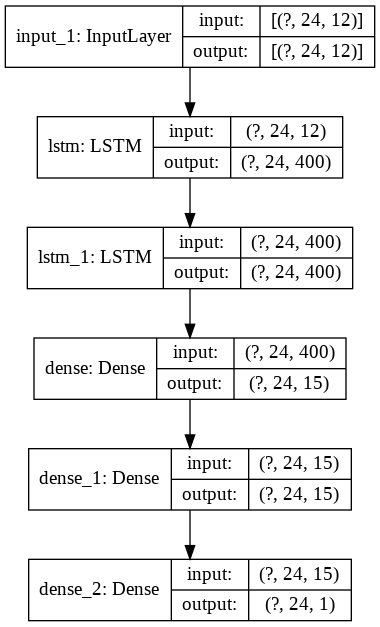

In [9]:
inputs = keras.Input(shape=(24,12))
x0=lstm1(inputs)    
x1 = lstm2(x0)
x2 = mlp1(x1)
x3=mlp2(x2)
x4=mlp3(x3)
S_model = keras.Model(inputs=inputs, outputs=x4, name="S_DTO-DRNN_2LSTM")
S_model.summary()
plot_model(S_model, to_file="S_DTO_model_2LSTM.png", show_shapes=True)

In [ ]:
CE = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction=losses_utils.ReductionV2.AUTO,
    name='binary_crossentropy')
S_model.compile( optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                loss="CE",
                metrics=[CE])

In [ ]:
EPOCHS= 10
history = DRNN_model.fit(X_train, Y_train,
                   validation_data=(X_test, Y_test),
                   epochs=EPOCHS,
                  batch_size=21600, # you can use the make_input_fn as well.
                  callbacks=[tfdocs.modeling.EpochDots()])

# **Plot some results**
Firstly, we should get some stats from the history of the training.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Then we plot accuracy vs epochs

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

plot_roc_curve(fpr, tpr)

In [ ]:
plt.title("Training and Validation errors")
plt.plot(hist['epoch'], hist['root_mean_squared_error'], color = "blue", label="train")
plt.plot(hist['epoch'], hist['val_root_mean_squared_error'], color = "red", label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

# **To distribute the calculation between multiple GPUs**

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  model = S_model
  model.compile(optimizer="rmsprop",loss ="mse", metrics=['MeanSquaredError'])
  model.fit(X_train_electricity, Y_train_electricity,
                   validation_data=(X_test_electricity, Y_test_electricity))